In [24]:
from permutated_CNN.model.ResNet_structure import *
from permutated_CNN.model.CNN_structure import *
## Pytorch Version
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import pandas as pd
import os
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import scipy.stats as stats
import statsmodels.api as sm


# Utils Functions

In [2]:
def get_network_result(select_type, model, device, criterion, table_columns, batch_size=8):
    network_type = select_type
    print(network_type.upper())
    # X_test = np.load(f'/home/eeepc/Documents/image_genes/test_data/permutated_gene_image_{network_type}.npy')
    X_test = np.load(f'/home/eeepc/Documents/image_genes/test_data/{network_type}_profile_image.npy')
    
    y_test = pd.read_csv(f'/home/eeepc/Documents/image_genes/test_data/{network_type}_rates_data.csv')
    # print(y_test.value_counts())
    y_test = y_test.iloc[:, 10:].values

#    # Get the number of columns in the second dimension
#     num_columns = X_test.shape[1]

#     # Create a random permutation of column indices
#     permuted_indices = np.random.permutation(num_columns)

#     # Use the permutation to shuffle the columns of the 3D matrix along axis 1
#     shuffled_matrix_3d = np.take_along_axis(X_test, permuted_indices[None, :, None], axis=1)

#     X_test = shuffled_matrix_3d
    
    X_test = X_test[:, None, :, :]
    

    test_dataset = RegressionDataset(X_test, y_test)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

    prediction_list = []
    truth_list = []

    test_loss = 0

    model.eval()
    with torch.no_grad():
        for test_inputs, test_targets in test_dataloader:
            # Transfer validation data to GPU
            test_inputs = test_inputs.to(device)
            prediction_tf = model.forward(test_inputs)
            test_loss += criterion(prediction_tf.detach().cpu(), test_targets).item()
            predictions = pd.DataFrame(prediction_tf.detach().cpu().numpy())
            prediction_list.append(predictions)
            truth_list.append(pd.DataFrame(test_targets.numpy()))
            

    predictions = pd.concat(prediction_list, axis=0)
    predictions.columns = table_columns
    truth = pd.concat(truth_list, axis=0)
    truth.columns = table_columns

    return predictions, truth, network_type, X_test, y_test

def model_predict(X_test, y_test, model, device, criterion, table_columns, batch_size=8):
    test_dataset = RegressionDataset(X_test, y_test)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

    prediction_list = []
    truth_list = []

    test_loss = 0

    model.eval()
    with torch.no_grad():
        for test_inputs, test_targets in test_dataloader:
            # Transfer validation data to GPU
            test_inputs = test_inputs.to(device)
            prediction_tf = model.forward(test_inputs)
            test_loss += criterion(prediction_tf.detach().cpu(), test_targets).item()
            predictions = pd.DataFrame(prediction_tf.detach().cpu().numpy())
            prediction_list.append(predictions)
            truth_list.append(pd.DataFrame(test_targets.numpy()))
            

    predictions = pd.concat(prediction_list, axis=0)
    predictions.columns = table_columns
    truth = pd.concat(truth_list, axis=0)
    truth.columns = table_columns

    return predictions, truth

def get_CI_predictions(select_type, predictions, truth, SEs, z_score, index):    
    print(f'{predictions.columns[index]}' , end = ' : ')
    # print(f'SEs {SEs}')
    # print(f'Z score {z_score}')
    CI_values = z_score * SEs
    # print(f'CI {round(CI_values.iloc[:, index],2)}')
    predict_p = (np.abs(predictions - truth).iloc[:, index] < CI_values.iloc[:, index].values.item())
    return predict_p


def get_compare_result(evolCCM_select, models, models_name, device, criterion, table_columns, batch_size):
    directory ='/home/eeepc/Documents/image_genes/'
    if evolCCM_select == 'star':
        star_mle = pd.read_csv(f"{directory}MLE_Method/star/predicted_data.csv")
        star_mle = star_mle.iloc[:, -10:]
        y_test = pd.read_csv(f'{directory}test_data/{evolCCM_select}_rates_data.csv').iloc[:, 10:]
    elif evolCCM_select == 'two_triangles':
        star_mle = pd.read_csv("/home/eeepc/Documents/image_genes/MLE_Method/two_triangles_predicted_data.csv")
        star_mle = star_mle.iloc[:, -10:]
        y_test = pd.read_csv(f'{directory}/test_data/{evolCCM_select}_rates_data.csv').iloc[:, 10:]
    elif evolCCM_select == 'line':
        star_mle = pd.read_csv("/home/eeepc/Documents/image_genes/MLE_Method/line_predicted_data.csv")
        star_mle = star_mle.iloc[:, -10:]
        y_test = pd.read_csv(f'{directory}/test_data/{evolCCM_select}_rates_data.csv').iloc[:, 10:]

    predictions = star_mle
    truth_mle = pd.DataFrame(y_test.iloc[:100,], columns = predictions.columns)

    SEs_df_mle = [0.4040456, 0.4531348, 0.4104203, 0.3955997, 0.4090854, 0.4456595, 0.4339634, 0.4251135, 0.4557958, 0.4352029]

    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report
    from sklearn.metrics import roc_curve, auc


    shapes = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']

    plt.figure(figsize=(8, 6))

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    # z_score = [0, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 1.036, 1.150, 1.282, 1.440, 1.645, 1.96, 2.23,10]
    z_score = np.linspace(0, 10, 100)
    shape_index = 0
    x_axis = []
    y_axis = []

    for z in z_score:
        predictions_edge = np.abs(star_mle.divide(SEs_df_mle.values)) > z
        truth_edge = pd.melt(truth_mle*2)
        predictions_edge = pd.melt(predictions_edge)
        conf_matrix = confusion_matrix(truth_edge.iloc[:, 1], predictions_edge.iloc[:, 1])
        # Extract values from the confusion matrix
        TN, FP, FN, TP = conf_matrix.ravel()

        # Calculate sensitivity and specificity
        sensitivity = TP / (TP + FN)
        specificity = TN / (TN + FP)
        # Calculate ROC curve
        fpr, tpr, thresholds = roc_curve(truth_edge.iloc[:, 1], predictions_edge.iloc[:, 1])

        # Calculate Area Under the Curve (AUC)
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve
        x_axis.append(1 - specificity)
        y_axis.append(sensitivity)
        
    plt.plot(x_axis, y_axis, lw=2, label=f'evolCCM {evolCCM_select}')


    for model_id, model in enumerate(models):
        predictions, truth, network_type = get_network_result(evolCCM_select, model, device, criterion, table_columns, batch_size)
        shape_index = 0
        x_axis = []
        y_axis = []

        # SEs_df_mle = (predictions - truth.iloc[:100,]).std()

        for z in z_score:
            predictions_edge = np.abs(predictions / 0.23) > z
            truth_edge = pd.melt(truth*2)
            predictions_edge = pd.melt(predictions_edge)
            conf_matrix = confusion_matrix(truth_edge.iloc[:, 1], predictions_edge.iloc[:, 1])
            # Extract values from the confusion matrix
            TN, FP, FN, TP = conf_matrix.ravel()

            # Calculate sensitivity and specificity
            sensitivity = TP / (TP + FN)
            specificity = TN / (TN + FP)
            # Calculate ROC curve
            fpr, tpr, thresholds = roc_curve(truth_edge.iloc[:, 1], predictions_edge.iloc[:, 1])

            # Calculate Area Under the Curve (AUC)
            roc_auc = auc(fpr, tpr)

            # Plot ROC curve
            x_axis.append(1 - specificity)
            y_axis.append(sensitivity)

        plt.plot(x_axis, y_axis, lw=2, label=f'{models_name[model_id]} CNN {network_type.upper()}')


    plt.xlabel('False Positive Rate ; (1 - Specificity)')
    plt.ylabel('True Positive Rate')
    plt.title(f'{evolCCM_select.upper()} Sensitivity vs. (1 - Specificity)')
    plt.legend(loc='lower right')
    plt.show()

    # print(x_axis)
    return x_axis, y_axis


def draw_FDR_curve(predictions_array, truth, permutated_orders):
    my_array = np.arange(1, 101, 1)
    z_score = []
    for i in range(1, 100, 1):
        q25 = norm.ppf(0.01 * i/2)
        z_score.append(np.abs(q25))
        

    plt.rcParams.update({'font.size': 14})
    plt.figure(figsize=(15, 15))
    plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color = 'red')


    SEs_df_mle = [0.23231547, 0.22970757, 0.23109926, 0.23222223, 0.23208608, 0.23138598, 0.23122062, 0.23031087, 0.23166709, 0.23061362]

    for i_index, predictions in tqdm(enumerate(predictions_array),  total= len(predictions_array)):
        x_axis = []
        y_axis = []
        index = 0
        for z in z_score:
            predictions_edge = np.abs(predictions.divide(0.23)) > z
            truth_edge = pd.melt(truth*2)
            truth_edge = (truth_edge == 1)
            predictions_edge = pd.melt(predictions_edge)
            total_melt = pd.concat([truth_edge, predictions_edge], axis=1)
            # Plot ROC curve
            x_axis.append(my_array[index] * 0.01)
            # y_axis.append(((truth_edge.iloc[:, 1] == 0) == (predictions_edge.iloc[:, 1] == 1) ).sum() / (truth_edge.iloc[:, 1] == 0).sum())
            y_axis.append(total_melt[truth_edge.iloc[:,1] == False].iloc[:, 3].sum() / len(total_melt[truth_edge.iloc[:,1] == False].iloc[:, 3]))
            # print(np.round(z,2))
            # if np.round(z,2) == 1.92:
                # plt.scatter(1 - specificity, sensitivity, color = 'blue',label = 'CNN', s=100)
            index += 1
        plt.plot(x_axis, y_axis, lw=2, label=f'Pure Uniform ResNet32 CNN {permutated_orders[i_index]}')
    
    plt.xlabel('Critical Value')
    plt.ylabel('False Reject Rate')
    plt.title(f'Size Curve: Critical Value v.s. False Reject Rate')
    plt.legend(loc='lower right')
    plt.yticks(np.arange(0, 1.01, step=0.1))
    plt.xticks(np.arange(0, 1.01, step=0.05))
    plt.legend(ncol=3, loc='center left', bbox_to_anchor=(1.02, 0.5))
    plt.ylim(0, 1)
    # plt.xlim(0, 1)
    plt.show()


from itertools import permutations
from scipy.stats import norm

def generate_permutations():
    elements = [0, 1, 2, 3, 4]
    permutations_list = list(permutations(elements))
    # Convert tuples to lists
    permutations_list = [list(permutation) for permutation in permutations_list]
    return permutations_list


    

def get_permutated_predictions(all_permutations, permutation_selection, X_test, y_test, model, device, criterion, table_columns, batch_size=8):
    result = ['12', '13', '23', '14', '24', '34', '15', '25', '35', '45']
    result_with_prefix = [f"beta_{x}" for x in result]
    selected_permutated = all_permutations[permutation_selection]
    genes_new_permutation = np.tile(selected_permutated, 40)
    reordered_arr = X_test[:, :, :, genes_new_permutation]
    permutated_predictions, permutated_truth = model_predict(reordered_arr, y_test, model, device, criterion, table_columns, batch_size=8)
    gene_original_order = [(1,2), (1,3), (2,3), (1,4), (2,4), (3,4), (1,5), (2,5), (3,5), (4,5)]
    permutated_orders = []
    for x,y in gene_original_order:
        sorted_comb = tuple(sorted((selected_permutated[x-1] + 1, selected_permutated[y-1] + 1 )))
        permutated_orders.append('beta_' + str(int(''.join(map(str, sorted_comb)))))
    permutated_predictions.columns = permutated_orders
    permutated_predictions = permutated_predictions.loc[:,result_with_prefix ]
    return permutated_predictions

In [3]:
batch_size = 8
input_shape = (1,100,200)
num_outputs = 10

network_name = ["line", "two_triangles", "star", "full_connected"]
table_columns = ['beta_12', 'beta_13', 'beta_14', 'beta_15', 'beta_23', 'beta_24', 'beta_25', 'beta_34', 'beta_35', 'beta_45']
network_all_types = ['line', 'star', 'two_triangles', 'fully_connected'] 

In [4]:
model_parameters={}
model_parameters['resnet18'] = ([64,128,256,512],[2,2,2,2],1,False)
model_parameters['resnet34'] = ([64,128,256,512],[3,4,6,3],1,False)
model_parameters['resnet50'] = ([64,128,256,512],[3,4,6,3],4,True)
model_parameters['resnet101'] = ([64,128,256,512],[3,4,23,3],4,True)
model_parameters['resnet152'] = ([64,128,256,512],[3,8,36,3],4,True)

# checkpoint_path = '/home/eeepc/Documents/random_tree/code_base/temperary_data_saver/model_checkpoints/02_11_18_51_12_duplicates_CNN_2_Million_10_epochs_1_batch_no_dropout/batch_best_model_0.066.pth'
# model = RegressionCNN(input_shape, num_outputs)

# architecture_setting = model_parameters['resnet34']

architecture_setting = model_parameters['resnet50']


# Initialize your model
# Define the path to the checkpoint file
# checkpoint_path = "./temperary_data_saver/model_checkpoints/02_12_00_08_01_duplicates_ResNet_18_2_Million_10_epochs_1_batch_no_dropout/batch_best_model_0.085.pth"

# checkpoint_path = "/home/eeepc/Documents/random_tree/code_base/temperary_data_saver/mixture_uniform/model_checkpoints/02_12_01_49_31_duplicates_ResNet_34_no_dropout_1e4/batch_best_model_0.053.pth"

checkpoint_path = "/home/eeepc/Documents/random_tree/code_base/temperary_data_saver/pure_uniform_4million/model_checkpoints/02_15_15_00_07_random_sampled_pure_uniform_permutated_ResNet_34_1e3/batch_best_model_0.066.pth"


model = ResNet(architecture_setting, in_channels=1, num_classes = num_outputs)

# Load the state dictionary from the checkpoint file
checkpoint = torch.load(checkpoint_path)

# Load the state dictionary into your model
model.load_state_dict(checkpoint)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

pure_uniform_model = model 

# FDR curve

## CNN v.s. CCM

In [6]:
directory = '/home/eeepc/Documents/random_tree/code_base/test_data/prediction/200_new_version/'
estimate_rates_array = []
for types_name in network_name:
    estimate_rates_array.append(pd.read_csv(directory + types_name + '/estP.csv'))
estimate_rates = pd.concat(estimate_rates_array, axis = 0)
estimate_rates = estimate_rates.iloc[:, 10:]

estimate_SE_array = []
for types_name in network_name:
    estimate_SE_array.append(pd.read_csv(directory + types_name + '/estSE.csv'))
estimate_SE = pd.concat(estimate_SE_array, axis = 0)
estimate_SE = estimate_SE.iloc[:, 10:]

truth_rates_array = []
for types_name in network_name:
    truth_rates_array.append(pd.read_csv(directory + types_name + '/rates_data.csv'))
truth_rates = pd.concat(truth_rates_array, axis = 0)
truth_rates = truth_rates.iloc[:, 10:]

In [67]:

# evolCCM_select = network_all_types[0]
predictions_array = []
truth_array = []
for evolCCM_select in network_all_types[:1]:
    predictions, truth, network_type, _, _ = get_network_result(evolCCM_select, pure_uniform_model, device, criterion, table_columns, batch_size)
    predictions_array.append(predictions)
    truth_array.append(truth)
# shape_index = 0

predictions = pd.concat(predictions_array, axis = 0)
truth = pd.concat(truth_array, axis = 0)


LINE


In [68]:
p_value_predictions = pd.DataFrame(2 * (1 - stats.norm.cdf(abs(predictions / 0.23))))
p_value_predictions.columns = predictions.columns

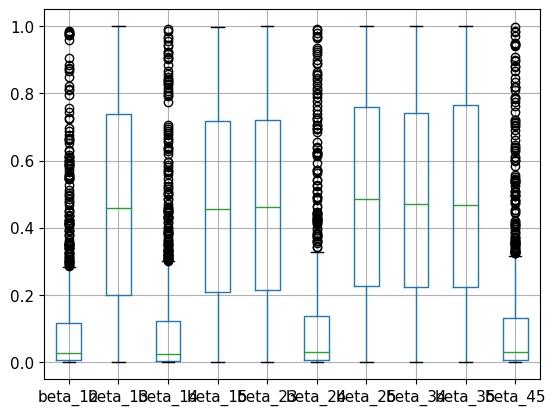

In [69]:
p_value_predictions.boxplot()
plt.show()

In [71]:
# Apply Benjamini-Hochberg correction to each row
corrected_p_values = []
for index, row in p_value_predictions.iterrows():
    _, row_corrected_p_values, _, _ = sm.stats.multipletests(row, method='fdr_bh')
    corrected_p_values.append(row_corrected_p_values)

# Create a new DataFrame with corrected p-values
corrected_df = pd.DataFrame(corrected_p_values, columns=predictions.columns)


In [72]:
corrected_df

,beta_12,beta_13,beta_14,beta_15,beta_23,beta_24,beta_25,beta_34,beta_35,beta_45
0,0.028455,0.039072,0.643451,0.341245,0.975178,0.028455,0.812339,0.955549,0.812339,0.034634
1,0.020366,0.242541,0.073137,0.419996,0.342945,0.138675,0.018513,0.419996,0.242541,0.692366
2,0.145537,0.744734,0.096419,0.600762,0.203322,0.744734,0.744734,0.046529,0.247566,0.213598
3,0.008692,0.693965,0.157186,0.075452,0.046364,0.191133,0.327547,0.241270,0.191133,0.011113
4,0.020962,0.754923,0.020962,0.798229,0.938115,0.008286,0.754589,0.798229,0.288889,0.041934
...,...,...,...,...,...,...,...,...,...,...
995,0.283556,0.497454,0.029623,0.648320,0.912629,0.029623,0.912629,0.778767,0.912629,0.497454
996,0.252971,0.361526,0.006357,0.660629,0.529168,0.129872,0.252971,0.404359,0.252971,0.361526
997,0.014093,0.990252,0.077052,0.242918,0.990252,0.990252,0.144240,0.990252,0.990252,0.014093
998,0.735961,0.435329,0.200949,0.735961,0.239155,0.012389,0.340800,0.760046,0.239155,0.012389


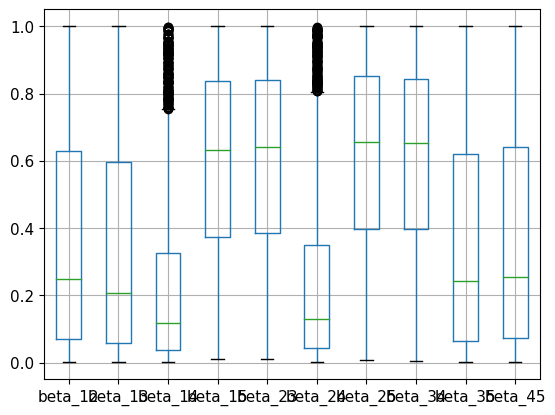

In [63]:
corrected_df.boxplot()
plt.show()

/tmp/ipykernel_1226480/3804246535.py:34: RuntimeWarning: invalid value encountered in scalar divide
  FDR = FP / (FP + TP)


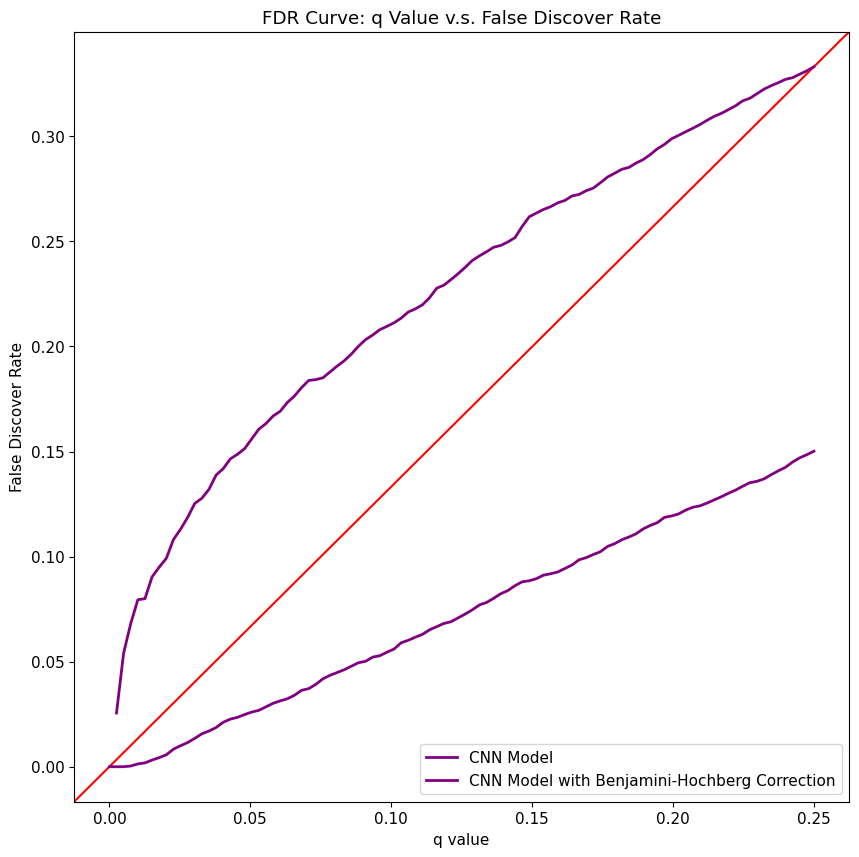

In [80]:
from scipy.stats import norm
my_array = np.arange(1, 110, 1)
z_score = []

q_values = np.linspace(0, 0.25, 100)

for i in range(1, 30, 1):
    q25 = norm.ppf(0.01 * i/2)
    z_score.append(np.abs(q25))

plt.rcParams.update({'font.size': 11})

plt.figure(figsize=(10, 10))

plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color = 'red')


x_axis = []
y_axis = []

index = 0

for q in q_values:
    predictions_edge = p_value_predictions < q
    truth_edge = pd.melt(truth*2)
    truth_edge = (truth_edge == 1)
    predictions_edge = pd.melt(predictions_edge)
    total_melt = pd.concat([truth_edge, predictions_edge], axis=1)

    conf_matrix = confusion_matrix(truth_edge.iloc[:, 1], predictions_edge.iloc[:, 1])
    # Extract values from the confusion matrix
    TN, FP, FN, TP = conf_matrix.ravel()
    FDR = FP / (FP + TP)
    # Plot ROC curve
    x_axis.append(q)
    # y_axis.append(((truth_edge.iloc[:, 1] == 0) == (predictions_edge.iloc[:, 1] == 1) ).sum() / (truth_edge.iloc[:, 1] == 0).sum())
    # y_axis.append(total_melt[truth_edge.iloc[:,1] == False].iloc[:, 3].sum() / len(total_melt[truth_edge.iloc[:,1] == False].iloc[:, 3]))
    y_axis.append(FDR)
    
    # print(np.round(z,2))
    # if np.round(z,2) == 1.92:
        # plt.scatter(1 - specificity, sensitivity, color = 'blue',label = 'CNN', s=100)
    index += 1
    
plt.plot(x_axis, y_axis, lw=2, color = 'purple', label=f'CNN Model')


x_axis = []
y_axis = []

index = 0

for q in q_values:
    predictions_edge = corrected_df < q
    truth_edge = pd.melt(truth*2)
    truth_edge = (truth_edge == 1)
    predictions_edge = pd.melt(predictions_edge)
    total_melt = pd.concat([truth_edge, predictions_edge], axis=1)
    # Plot ROC curve
    x_axis.append(q)
    # y_axis.append(((truth_edge.iloc[:, 1] == 0) == (predictions_edge.iloc[:, 1] == 1) ).sum() / (truth_edge.iloc[:, 1] == 0).sum())
    y_axis.append(total_melt[truth_edge.iloc[:,1] == False].iloc[:, 3].sum() / len(total_melt[truth_edge.iloc[:,1] == False].iloc[:, 3]))
    # print(np.round(z,2))
    # if np.round(z,2) == 1.92:
        # plt.scatter(1 - specificity, sensitivity, color = 'blue',label = 'CNN', s=100)
    index += 1
    
plt.plot(x_axis, y_axis, lw=2, color = 'purple', label=f'CNN Model with Benjamini-Hochberg Correction')

plt.xlabel('q value')
plt.ylabel('False Discover Rate')
plt.title(f'FDR Curve: q Value v.s. False Discover Rate')
plt.legend(loc='lower right')
# plt.yticks(np.arange(0, 1.01, step=0.1))
# plt.xticks(np.arange(0, 1.01, step=0.05))
# plt.ylim(0, 0.25)
# plt.xlim(0, 0.25)
plt.show()



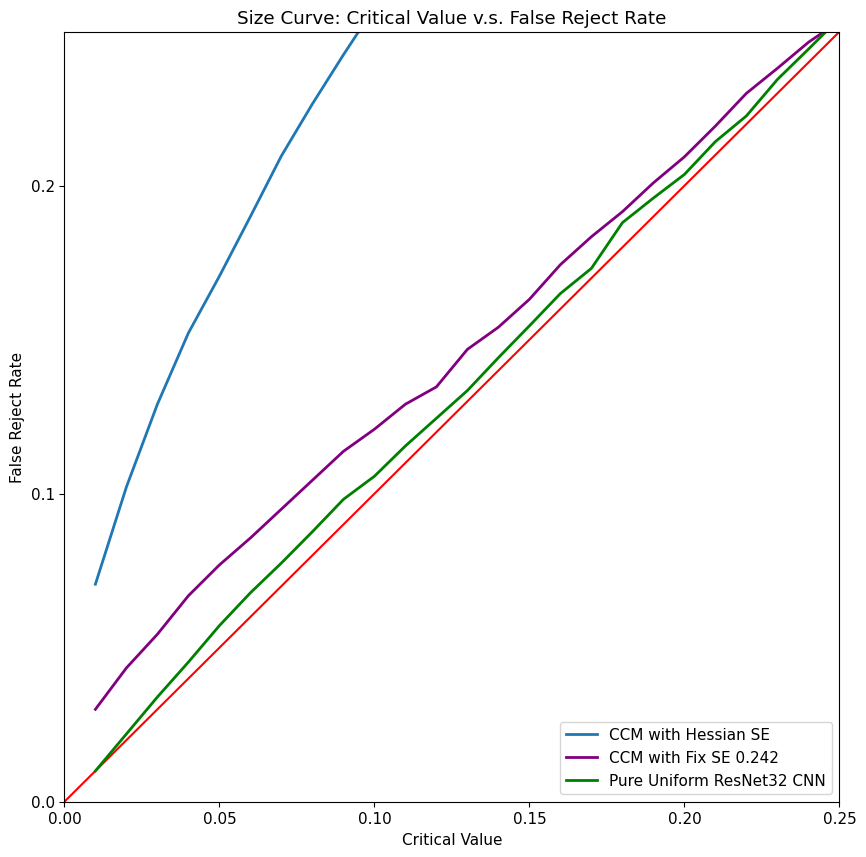

In [29]:
from scipy.stats import norm
my_array = np.arange(1, 30, 1)
z_score = []

for i in range(1, 30, 1):
    q25 = norm.ppf(0.01 * i/2)
    z_score.append(np.abs(q25))

plt.rcParams.update({'font.size': 11})

plt.figure(figsize=(10, 10))

plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color = 'red')

x_axis = []
y_axis = []
SEs_df_mle = [0.23231547, 0.22970757, 0.23109926, 0.23222223, 0.23208608, 0.23138598, 0.23122062, 0.23031087, 0.23166709, 0.23061362]

index = 0

for z in z_score:
    predictions_edge = np.abs(estimate_rates.divide(estimate_SE)) > z
    truth_edge = pd.melt(truth_rates*2)
    truth_edge = (truth_edge == 1)
    predictions_edge = pd.melt(predictions_edge)
    total_melt = pd.concat([truth_edge, predictions_edge], axis=1)
    # Plot ROC curve
    x_axis.append(my_array[index] * 0.01)
    # y_axis.append(((truth_edge.iloc[:, 1] == 0) == (predictions_edge.iloc[:, 1] == 1) ).sum() / (truth_edge.iloc[:, 1] == 0).sum())
    y_axis.append(total_melt[truth_edge.iloc[:,1] == False].iloc[:, 3].sum() / len(total_melt[truth_edge.iloc[:,1] == False].iloc[:, 3]))
    # print(np.round(z,2))
    # if np.round(z,2) == 1.92:
        # plt.scatter(1 - specificity, sensitivity, color = 'blue',label = 'CNN', s=100)
    index += 1
plt.plot(x_axis, y_axis, lw=2, label=f'CCM with Hessian SE')

x_axis = []
y_axis = []

index = 0

for z in z_score:
    predictions_edge = np.abs(estimate_rates.divide(0.242)) > z
    truth_edge = pd.melt(truth_rates*2)
    truth_edge = (truth_edge == 1)
    predictions_edge = pd.melt(predictions_edge)
    total_melt = pd.concat([truth_edge, predictions_edge], axis=1)
    # Plot ROC curve
    x_axis.append(my_array[index] * 0.01)
    # y_axis.append(((truth_edge.iloc[:, 1] == 0) == (predictions_edge.iloc[:, 1] == 1) ).sum() / (truth_edge.iloc[:, 1] == 0).sum())
    y_axis.append(total_melt[truth_edge.iloc[:,1] == False].iloc[:, 3].sum() / len(total_melt[truth_edge.iloc[:,1] == False].iloc[:, 3]))
    # print(np.round(z,2))
    # if np.round(z,2) == 1.92:
        # plt.scatter(1 - specificity, sensitivity, color = 'blue',label = 'CNN', s=100)
    index += 1
plt.plot(x_axis, y_axis, lw=2, color = 'purple', label=f'CCM with Fix SE 0.242')



x_axis = []
y_axis = []
SEs_df_mle = [0.23231547, 0.22970757, 0.23109926, 0.23222223, 0.23208608, 0.23138598, 0.23122062, 0.23031087, 0.23166709, 0.23061362]

index = 0

for z in z_score:
    predictions_edge = np.abs(predictions.divide(0.245)) > z
    truth_edge = pd.melt(truth*2)
    truth_edge = (truth_edge == 1)
    predictions_edge = pd.melt(predictions_edge)
    total_melt = pd.concat([truth_edge, predictions_edge], axis=1)
    # Plot ROC curve
    x_axis.append(my_array[index] * 0.01)
    # y_axis.append(((truth_edge.iloc[:, 1] == 0) == (predictions_edge.iloc[:, 1] == 1) ).sum() / (truth_edge.iloc[:, 1] == 0).sum())
    y_axis.append(total_melt[truth_edge.iloc[:,1] == False].iloc[:, 3].sum() / len(total_melt[truth_edge.iloc[:,1] == False].iloc[:, 3]))
    # print(np.round(z,2))
    # if np.round(z,2) == 1.92:
        # plt.scatter(1 - specificity, sensitivity, color = 'blue',label = 'CNN', s=100)
    index += 1
plt.plot(x_axis, y_axis, lw=2, color = 'green',  label=f'Pure Uniform ResNet32 CNN')
   

plt.xlabel('Critical Value')
plt.ylabel('False Reject Rate')
plt.title(f'Size Curve: Critical Value v.s. False Reject Rate')
plt.legend(loc='lower right')
plt.yticks(np.arange(0, 1.01, step=0.1))
plt.xticks(np.arange(0, 1.01, step=0.05))
plt.ylim(0, 0.25)
plt.xlim(0, 0.25)
plt.show()



## Reorder

In [5]:
from itertools import permutations
from scipy.stats import norm

def generate_permutations():
    elements = [0, 1, 2, 3, 4]
    permutations_list = list(permutations(elements))
    # Convert tuples to lists
    permutations_list = [list(permutation) for permutation in permutations_list]
    return permutations_list

In [6]:
result = ['12', '13', '23', '14', '24', '34', '15', '25', '35', '45']
result_with_prefix = [f"beta_{x}" for x in result]

evolCCM_select = network_all_types[0]
predictions_array = []
truth_array = []
for evolCCM_select in network_all_types:
    predictions, truth, network_type, X_test, y_test  = get_network_result(evolCCM_select, pure_uniform_model, device, criterion, table_columns, batch_size)
    predictions_array.append(predictions)
    truth_array.append(truth)
    break
# shape_index = 0

predictions = pd.concat(predictions_array, axis = 0)
predictions.columns = result_with_prefix
truth = pd.concat(truth_array, axis = 0)
truth.columns = result_with_prefix

LINE


In [7]:
def get_permutated_predictions(all_permutations, permutation_selection, X_test, y_test, model, device, criterion, table_columns, batch_size=8):
    selected_permutated = all_permutations[permutation_selection]
    genes_new_permutation = np.tile(selected_permutated, 40)
    reordered_arr = X_test[:, :, :, genes_new_permutation]
    permutated_predictions, permutated_truth = model_predict(reordered_arr, y_test, model, device, criterion, table_columns, batch_size=8)
    gene_original_order = [(1,2), (1,3), (2,3), (1,4), (2,4), (3,4), (1,5), (2,5), (3,5), (4,5)]
    permutated_orders = []
    for x,y in gene_original_order:
        sorted_comb = tuple(sorted((selected_permutated[x-1] + 1, selected_permutated[y-1] + 1 )))
        permutated_orders.append('beta_' + str(int(''.join(map(str, sorted_comb)))))
    permutated_predictions.columns = permutated_orders
    permutated_predictions = permutated_predictions.loc[:,result_with_prefix ]
    return permutated_predictions

In [224]:
# all_permutations = np.array(generate_permutations())
# permutated_predictions = get_permutated_predictions(all_permutations, 2, X_test, y_test, pure_uniform_model, device, criterion, table_columns, batch_size=8)

In [8]:
from tqdm.notebook import tqdm 
all_permutations = np.array(generate_permutations())

predictions_array = []
end_step = 120
for i in tqdm(range(end_step)):
    predictions_array.append(get_permutated_predictions(all_permutations, i, X_test, y_test, pure_uniform_model, device, criterion, table_columns, batch_size=8))

  0%|          | 0/120 [00:00<?, ?it/s]

In [9]:
# Initialize a DataFrame to store the sum
sum_df = pd.DataFrame()

# Sum all the DataFrames
for df in predictions_array:
    sum_df = sum_df.add(df, fill_value=0)


,beta_12,beta_13,beta_23,beta_14,beta_24,beta_34,beta_15,beta_25,beta_35,beta_45
0,0.674297,0.514785,0.168618,0.294063,-0.015199,0.706671,0.131259,-0.056434,-0.104839,0.607378
1,0.634604,-0.291743,0.507658,0.120220,-0.208056,0.439758,0.681857,0.236184,0.351572,0.130128
2,0.470674,0.075831,0.551987,-0.180659,0.326732,0.125103,-0.104090,-0.676189,0.364094,0.381211
3,0.772411,0.051221,0.392098,-0.538954,0.523990,0.373649,-0.174675,-0.381281,0.370339,0.732291
4,0.620733,0.160241,0.593718,-0.214995,0.081619,0.776203,-0.157369,0.075898,-0.276115,0.546597
...,...,...,...,...,...,...,...,...,...,...
3,0.443147,-0.355812,0.651697,0.157291,-0.020660,0.652248,0.041686,-0.208720,-0.016244,0.300231
4,0.395181,0.250082,0.790636,-0.098850,-0.155032,0.520190,-0.344430,-0.307168,0.399331,0.274552
5,0.691685,0.061253,0.488825,0.304522,-0.016938,0.057540,-0.394228,-0.018142,-0.008548,0.723854
6,0.112523,-0.248590,0.402306,0.157766,-0.279453,0.698128,-0.278784,-0.115320,-0.334839,0.741508


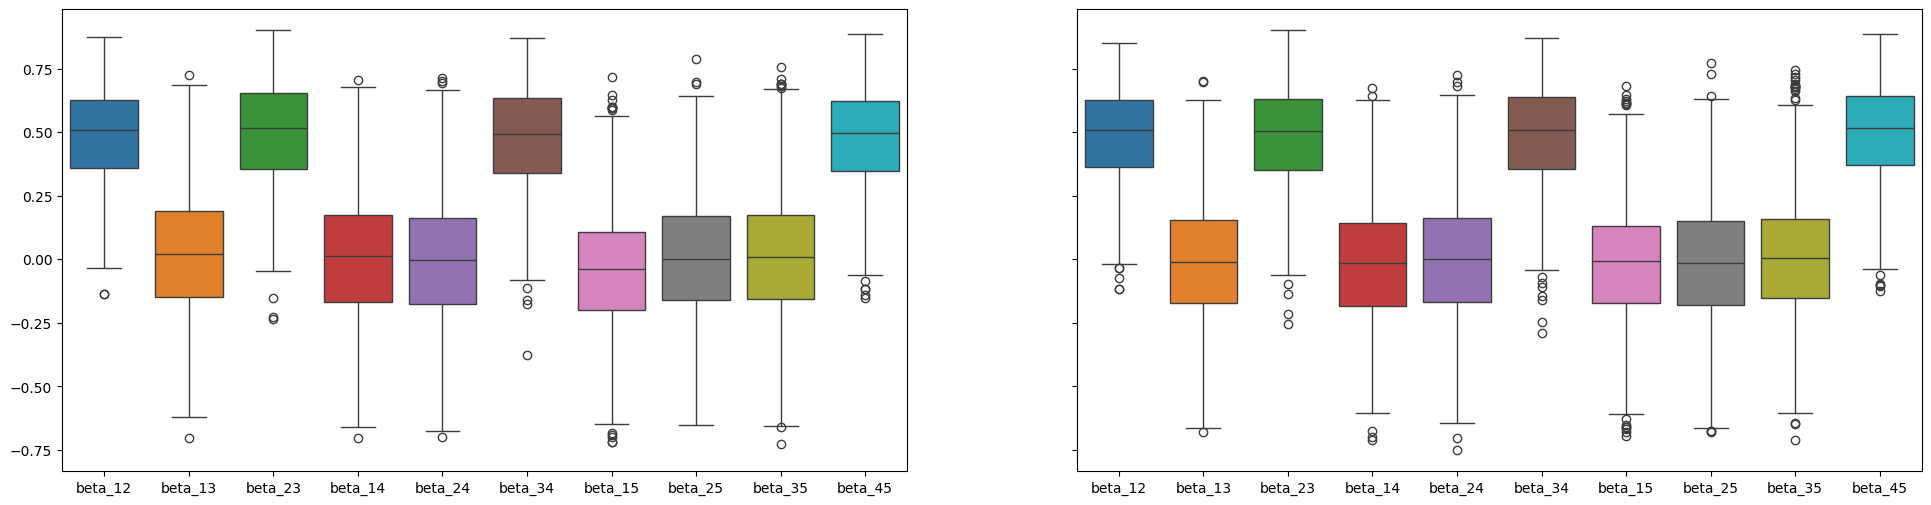

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt


# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(24, 6), sharey=True)
sns.boxplot(predictions, ax=axes[0])
sns.boxplot(sum_df / len(predictions_array), ax=axes[1])

# Show the plot
plt.show()


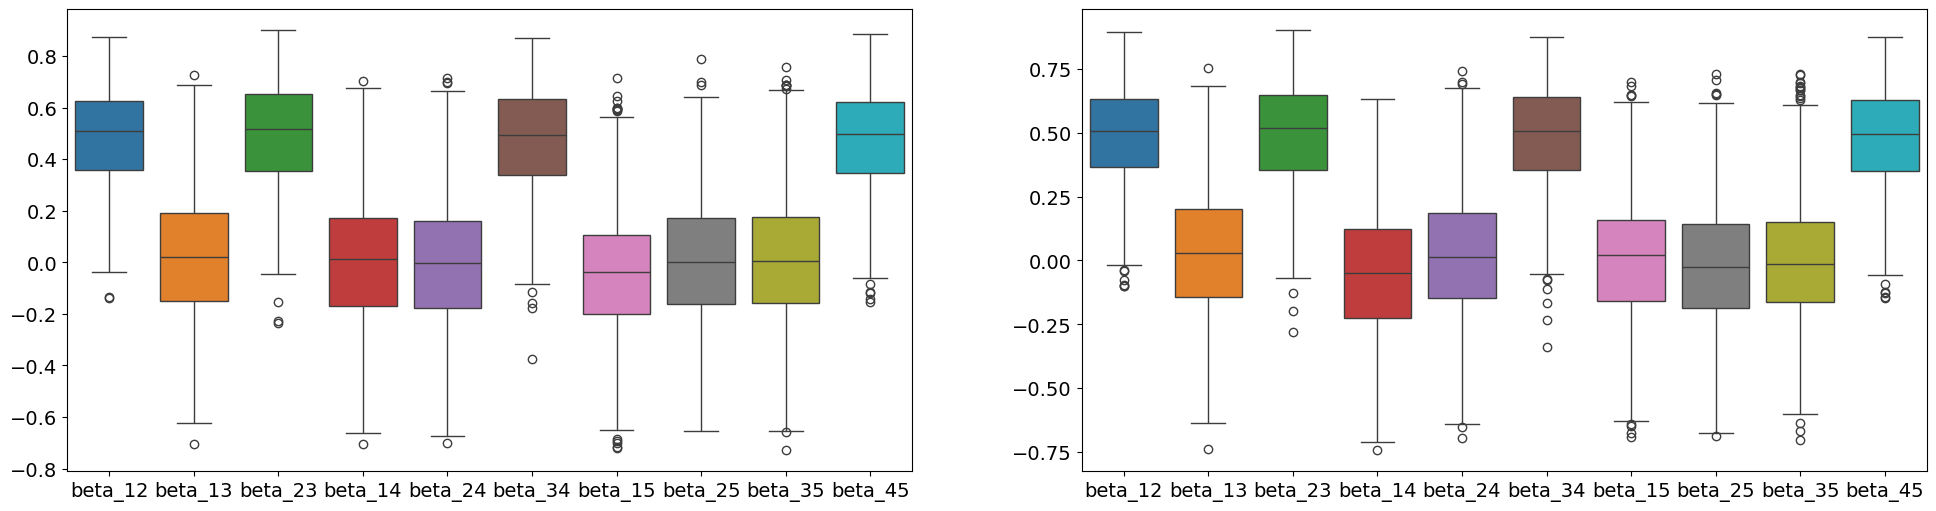

In [231]:
import seaborn as sns
import matplotlib.pyplot as plt


# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(24, 6), sharey=False)
sns.boxplot(predictions, ax=axes[0])
sns.boxplot(sum_df / len(predictions_array), ax=axes[1])

# Show the plot
plt.show()


In [11]:
def draw_FDR_curve(predictions_array, truth, permutated_orders):
    my_array = np.arange(1, 101, 1)
    z_score = []
    for i in range(1, 100, 1):
        q25 = norm.ppf(0.01 * i/2)
        z_score.append(np.abs(q25))
        

    plt.rcParams.update({'font.size': 14})
    plt.figure(figsize=(15, 15))
    plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color = 'red')


    SEs_df_mle = [0.23231547, 0.22970757, 0.23109926, 0.23222223, 0.23208608, 0.23138598, 0.23122062, 0.23031087, 0.23166709, 0.23061362]

    for i_index, predictions in tqdm(enumerate(predictions_array),  total= len(predictions_array)):
        x_axis = []
        y_axis = []
        index = 0
        for z in z_score:
            predictions_edge = np.abs(predictions.divide(0.23)) > z
            truth_edge = pd.melt(truth*2)
            truth_edge = (truth_edge == 1)
            predictions_edge = pd.melt(predictions_edge)
            total_melt = pd.concat([truth_edge, predictions_edge], axis=1)
            # Plot ROC curve
            x_axis.append(my_array[index] * 0.01)
            # y_axis.append(((truth_edge.iloc[:, 1] == 0) == (predictions_edge.iloc[:, 1] == 1) ).sum() / (truth_edge.iloc[:, 1] == 0).sum())
            y_axis.append(total_melt[truth_edge.iloc[:,1] == False].iloc[:, 3].sum() / len(total_melt[truth_edge.iloc[:,1] == False].iloc[:, 3]))
            # print(np.round(z,2))
            # if np.round(z,2) == 1.92:
                # plt.scatter(1 - specificity, sensitivity, color = 'blue',label = 'CNN', s=100)
            index += 1
        plt.plot(x_axis, y_axis, lw=2, label=f'Pure Uniform ResNet32 CNN {permutated_orders[i_index]}')
    
    plt.xlabel('Critical Value')
    plt.ylabel('False Reject Rate')
    plt.title(f'Size Curve: Critical Value v.s. False Reject Rate')
    plt.legend(loc='lower right')
    plt.yticks(np.arange(0, 1.01, step=0.1))
    plt.xticks(np.arange(0, 1.01, step=0.05))
    plt.legend(ncol=3, loc='center left', bbox_to_anchor=(1.02, 0.5))
    plt.ylim(0, 1)
    # plt.xlim(0, 1)
    plt.show()

  0%|          | 0/120 [00:00<?, ?it/s]

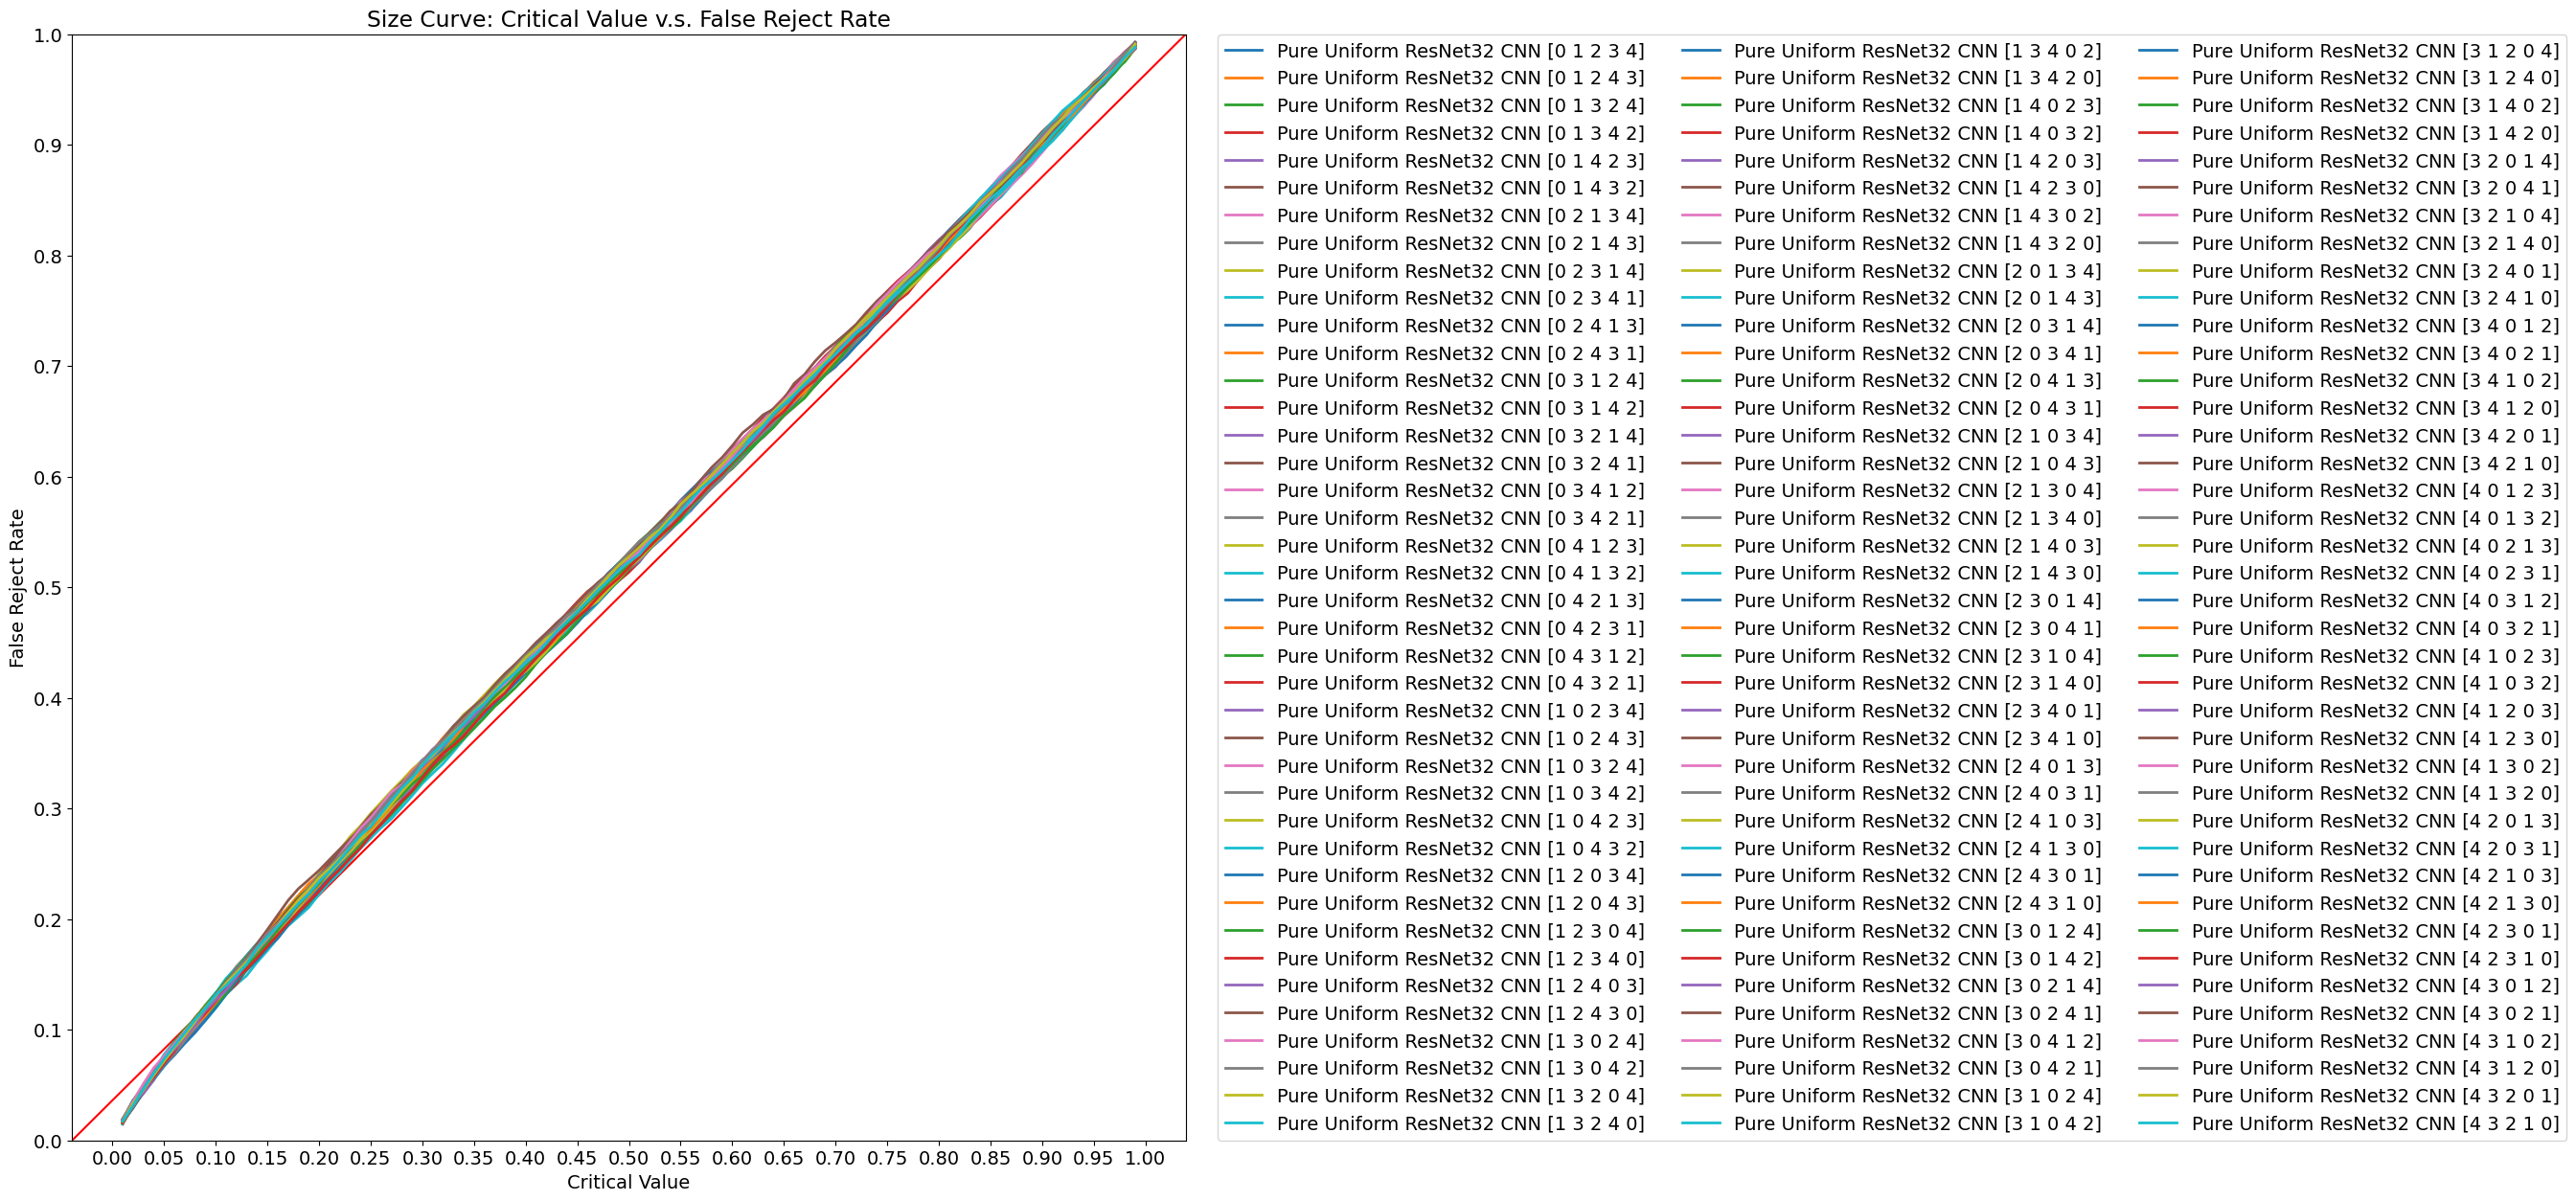

In [240]:
draw_FDR_curve(predictions_array, truth, all_permutations)

# Mirro Statistics

In [12]:
from tqdm.notebook import tqdm 
all_permutations = np.array(generate_permutations())

predictions_array = []

index_selection = np.random.randint(0, 120, 1).item()
print(index_selection)
predictions_array.append(get_permutated_predictions(all_permutations, 0, X_test, y_test, pure_uniform_model, device, criterion, table_columns, batch_size=8))
predictions_array.append(get_permutated_predictions(all_permutations, index_selection, X_test, y_test, pure_uniform_model, device, criterion, table_columns, batch_size=8))


77


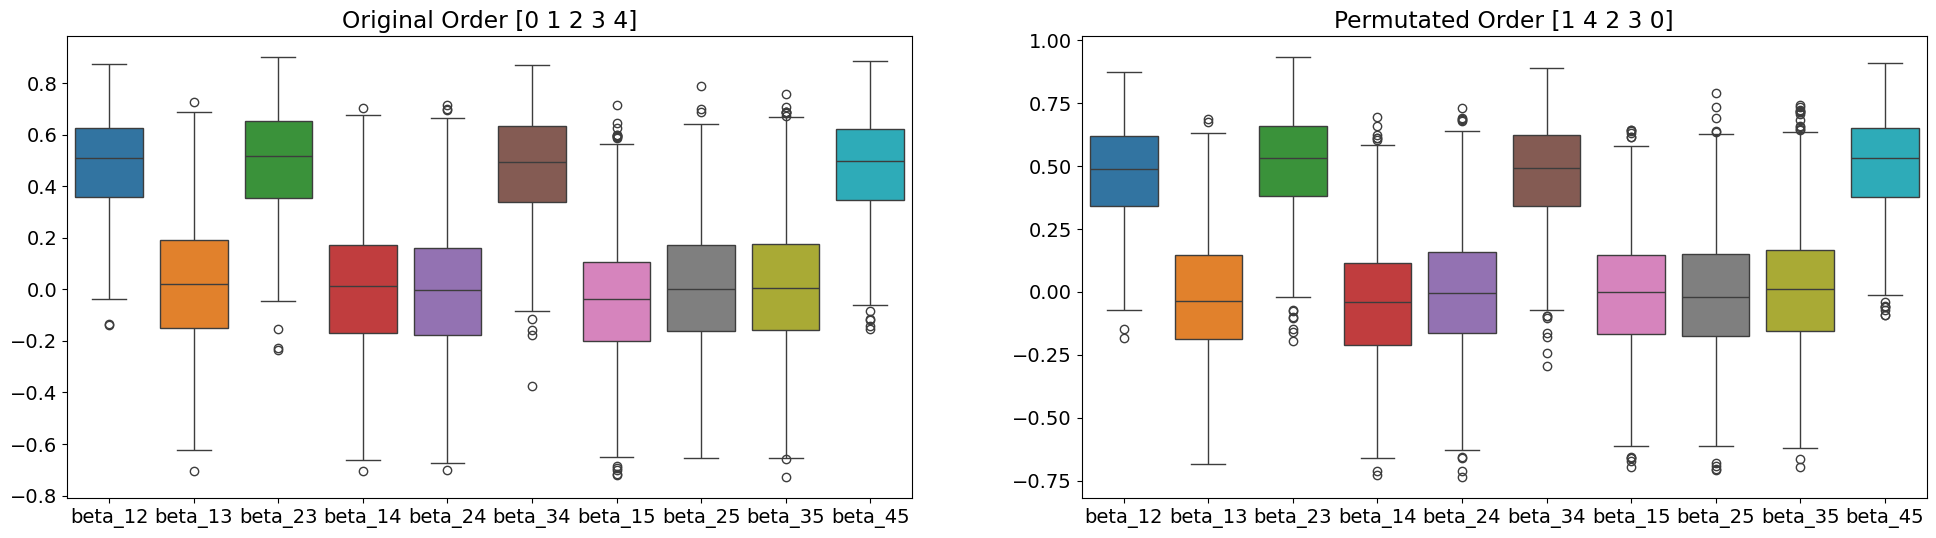

In [450]:
import seaborn as sns
import matplotlib.pyplot as plt


# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(24, 6), sharey=False)
sns.boxplot(predictions_array[0], ax=axes[0])
axes[0].set_title(f'Original Order {all_permutations[0]}')
sns.boxplot(predictions_array[1], ax=axes[1])
axes[1].set_title(f'Permutated Order {all_permutations[index_selection]}')

# Show the plot
plt.show()

In [13]:
original_prediction = pd.melt(predictions_array[0]).drop(columns = 'variable') / 0.23
permutated_prediction = pd.melt(predictions_array[1]).drop(columns = 'variable') / 0.23

In [480]:
from tqdm.notebook import tqdm 
all_permutations = np.array(generate_permutations())

predictions_array = []

for i in tqdm(range(len(all_permutations))):
    predictions_array.append(get_permutated_predictions(all_permutations, i, X_test, y_test, pure_uniform_model, device, criterion, table_columns, batch_size=8))

  0%|          | 0/120 [00:00<?, ?it/s]

In [481]:
melted_predictions = []
for predictions in predictions_array:
    melted_predictions.append(pd.melt(predictions).drop(columns = 'variable') / 0.23)

In [487]:
all_mirror = pd.concat(melted_predictions, axis = 1)

In [492]:
all_mirror_staistics = pd.DataFrame(all_mirror.mean(axis=1))

In [493]:
all_mirror_staistics

,0
0,2.931726
1,2.759148
2,2.046409
3,3.358312
4,2.698838
...,...
9995,1.305352
9996,1.193705
9997,3.147191
9998,3.223945


In [452]:
((original_prediction > 0) == (permutated_prediction > 0)).value_counts() / len(original_prediction)

value
True     0.9432
False    0.0568
Name: count, dtype: float64

In [14]:
Sign_df = pd.DataFrame(((original_prediction > 0) == (permutated_prediction > 0))).replace({True: 1, False: -1})

In [15]:
# Mirror_statistics = Sign_df * (np.abs(original_prediction) * np.abs(permutated_prediction))
Mirror_statistics = Sign_df * (np.abs(original_prediction) + np.abs(permutated_prediction))

In [21]:
Mirror_statistics

,value
0,5.715216
1,5.814704
2,4.241137
3,6.555885
4,5.429783
...,...
9995,2.392822
9996,2.822436
9997,6.277976
9998,6.593182


In [22]:
truth_melted = pd.melt(truth*2).drop(columns = 'variable')

In [29]:
truth_melted

,value
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
9995,1.0
9996,1.0
9997,1.0
9998,1.0


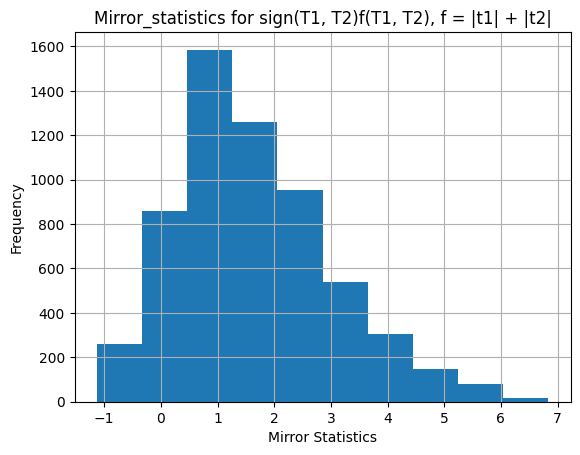

In [36]:
Mirror_statistics[truth_melted['value'] <0.5 ].hist()
plt.title("Mirror_statistics for sign(T1, T2)f(T1, T2), f = |t1| + |t2|")
plt.xlabel("Mirror Statistics")
plt.ylabel("Frequency")
plt.show()

In [472]:
t_arrays = np.linspace(0, 5, 100)
q = 0.02

tao_q = 0
for t in t_arrays:
    nominator = (Mirror_statistics < -t).sum().item() + 1
    denominator = max((Mirror_statistics > t).sum().item(), 1)
    FDP_t = nominator / denominator
    if FDP_t <= q:
        tao_q = t
        print(f"t = {t} FDP = {FDP_t} Nom = {nominator} Den = {denominator}")
        break

t = 0.45454545454545453 FDP = 0.017448447767958303 Nom = 154 Den = 8826


In [473]:
print("Accuracy", ((Mirror_statistics > tao_q) == pd.melt(pd.DataFrame(y_test*2)).drop(columns='variable')).sum().item() / len(Mirror_statistics))

Accuracy 0.5034


In [512]:
(((all_mirror_staistics > i * 0.05).values == pd.melt(pd.DataFrame(y_test*2)).drop(columns='variable')).values).sum() / len(all_mirror_staistics)

0.6

In [513]:
 pd.melt(pd.DataFrame(y_test*2)).drop(columns='variable')

,value
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
9995,1.0
9996,1.0
9997,1.0
9998,1.0


In [519]:
all_mirror_staistics.columns = ['value']

In [520]:
(all_mirror_staistics > i * 0.05)

,value
0,True
1,True
2,True
3,True
4,True
...,...
9995,True
9996,True
9997,True
9998,True


In [524]:
values

[value    0.7071
 dtype: float64,
 value    0.7186
 dtype: float64,
 value    0.7316
 dtype: float64,
 value    0.7418
 dtype: float64,
 value    0.7524
 dtype: float64,
 value    0.7614
 dtype: float64,
 value    0.7715
 dtype: float64,
 value    0.7822
 dtype: float64,
 value    0.791
 dtype: float64,
 value    0.8002
 dtype: float64,
 value    0.8082
 dtype: float64,
 value    0.8155
 dtype: float64,
 value    0.8238
 dtype: float64,
 value    0.83
 dtype: float64,
 value    0.8358
 dtype: float64,
 value    0.8401
 dtype: float64,
 value    0.8447
 dtype: float64,
 value    0.8507
 dtype: float64,
 value    0.8549
 dtype: float64,
 value    0.8587
 dtype: float64,
 value    0.8618
 dtype: float64,
 value    0.8652
 dtype: float64,
 value    0.867
 dtype: float64,
 value    0.8678
 dtype: float64,
 value    0.8695
 dtype: float64,
 value    0.8698
 dtype: float64,
 value    0.8686
 dtype: float64,
 value    0.8688
 dtype: float64,
 value    0.8681
 dtype: float64,
 value    0.866
 d

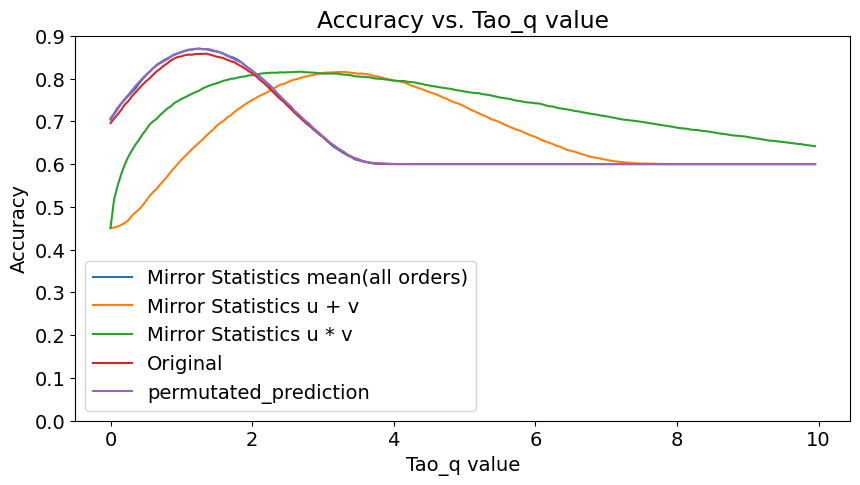

In [527]:
plt.figure(figsize=(10, 5))

values = []
upper_bound = 200


for i in range(0, upper_bound):
    # Mirror_statistics = Sign_df * (np.abs(original_prediction) + np.abs(permutated_prediction))
    value = (((all_mirror_staistics > i * 0.05).values == pd.melt(pd.DataFrame(y_test*2)).drop(columns='variable')).values).sum().item() / len(all_mirror_staistics)
    value = ((all_mirror_staistics > i * 0.05) == pd.melt(pd.DataFrame(y_test*2)).drop(columns='variable')).sum() / len(all_mirror_staistics)
    values.append(value)

plt.plot([i * 0.05 for i in range(upper_bound)], values, label = 'Mirror Statistics mean(all orders)')

values = []

for i in range(0, upper_bound):
    Mirror_statistics = Sign_df * (np.abs(original_prediction) + np.abs(permutated_prediction))
    value = ((Mirror_statistics > i * 0.05) == pd.melt(pd.DataFrame(y_test*2)).drop(columns='variable')).sum() / len(Mirror_statistics)
    values.append(value)

plt.plot([i * 0.05 for i in range(upper_bound)], values, label = 'Mirror Statistics u + v')

values = []
for i in range(0, upper_bound):
    Mirror_statistics = Sign_df * (np.abs(original_prediction) * np.abs(permutated_prediction))
    value = ((Mirror_statistics > i * 0.05) == pd.melt(pd.DataFrame(y_test*2)).drop(columns='variable')).sum() / len(Mirror_statistics)
    values.append(value)

plt.plot([i * 0.05 for i in range(upper_bound)], values, label = 'Mirror Statistics u * v')

values = []
for i in range(0, upper_bound):
    value = ((original_prediction > i * 0.05) == pd.melt(pd.DataFrame(y_test*2)).drop(columns='variable')).sum() / len(Mirror_statistics)
    values.append(value)

plt.plot([i * 0.05 for i in range(upper_bound)], values, label = 'Original')


values = []
for i in range(0, upper_bound):
    value = ((permutated_prediction > i * 0.05) == pd.melt(pd.DataFrame(y_test*2)).drop(columns='variable')).sum() / len(Mirror_statistics)
    values.append(value)

plt.plot([i * 0.05 for i in range(upper_bound)], values, label = 'permutated_prediction')

plt.ylim(0, 0.9)
plt.ylabel('Accuracy')
plt.xlabel("Tao_q value")
plt.title('Accuracy vs. Tao_q value')
plt.legend()
plt.show()

In [535]:
total_melt[truth_edge == False]

,value,value
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
9995,NaN,NaN
9996,NaN,NaN
9997,NaN,NaN
9998,NaN,NaN


In [538]:
predictions_edge


,beta_12,beta_13,beta_14,beta_15,beta_23,beta_24,beta_25,beta_34,beta_35,beta_45,value
0,False,False,False,False,False,False,False,False,False,False,False
0,False,False,False,False,False,False,False,False,False,False,False
0,False,False,False,False,False,False,False,False,False,False,False
0,False,False,False,False,False,False,False,False,False,False,False
0,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
9995,False,False,False,False,False,False,False,False,False,False,False
9996,False,False,False,False,False,False,False,False,False,False,False
9997,False,False,False,False,False,False,False,False,False,False,False
9998,False,False,False,False,False,False,False,False,False,False,False


In [548]:
all_predictions = predictions_array[0]

for predictions in predictions_array[1:]:
    all_predictions += predictions

all_predictions = all_predictions / len(predictions_array)

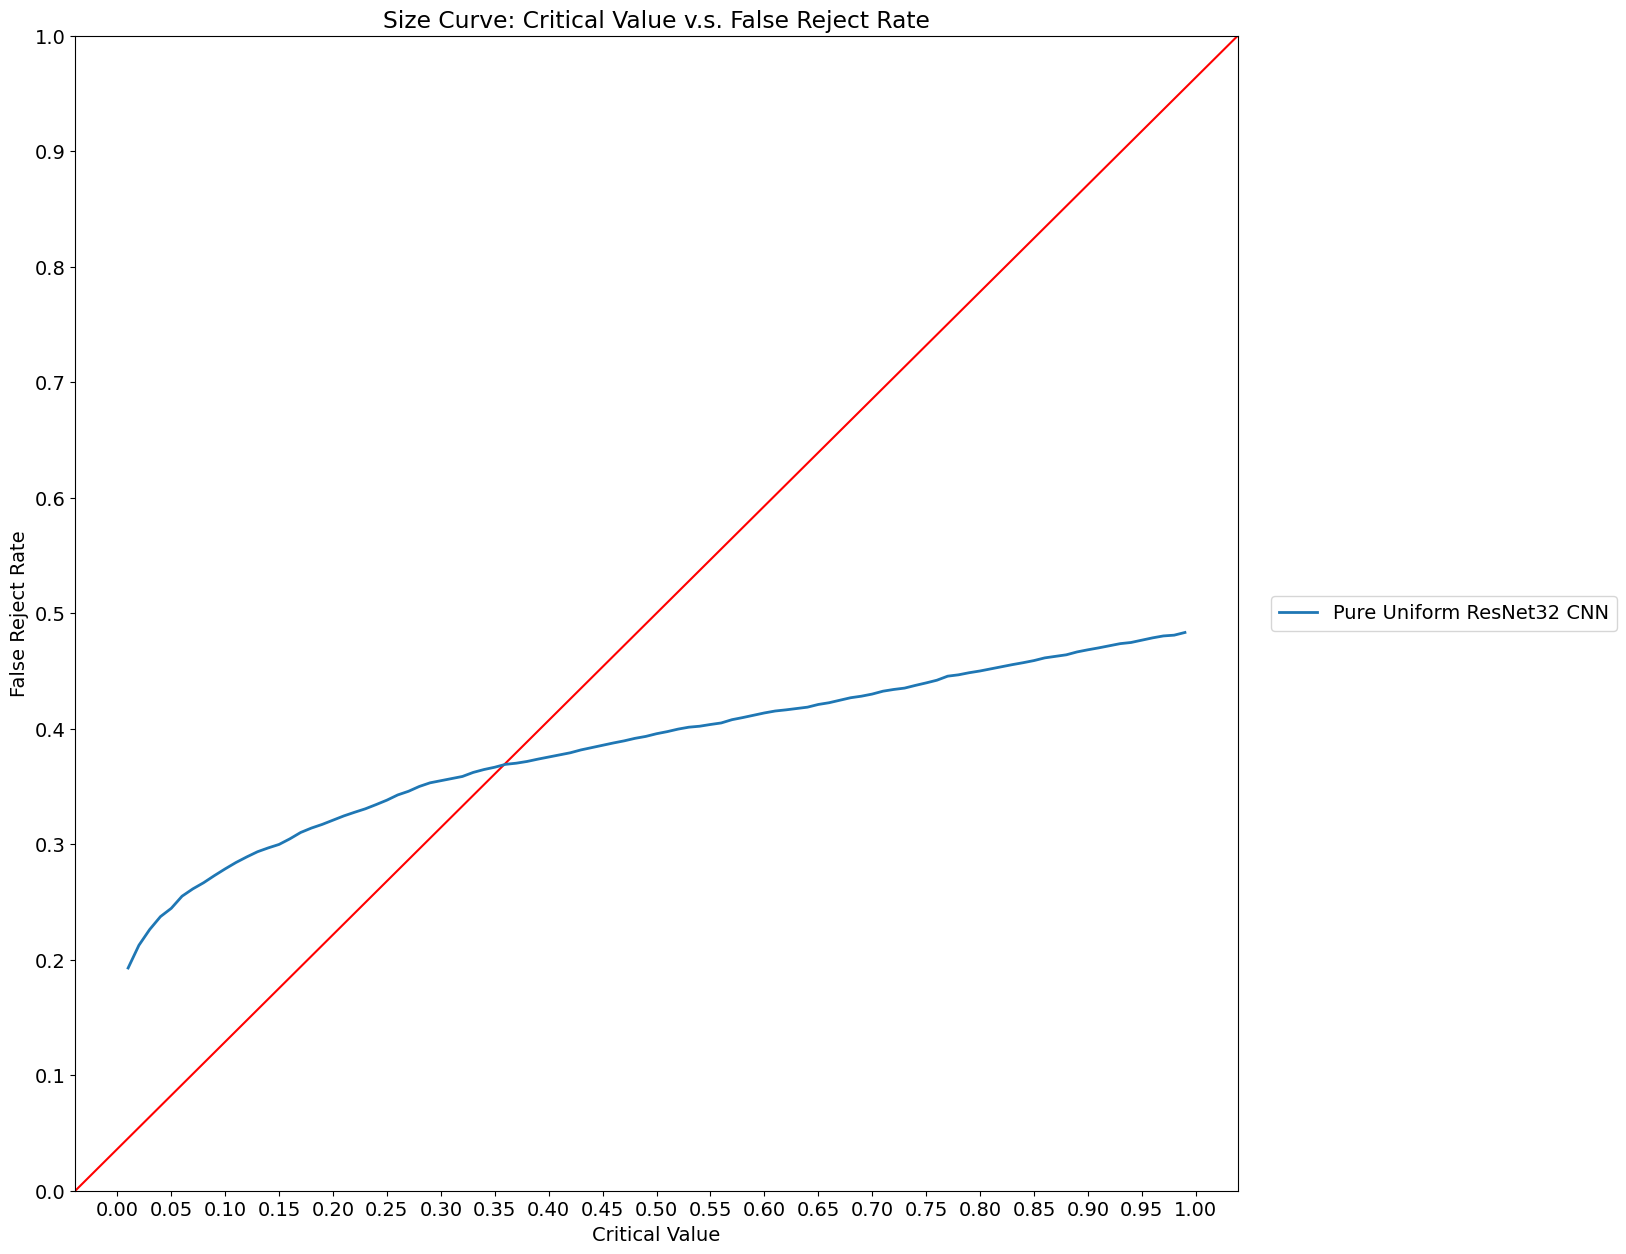

In [549]:
my_array = np.arange(1, 101, 1)
z_score = []
for i in range(1, 100, 1):
    q25 = norm.ppf(0.01 * i/2)
    z_score.append(np.abs(q25))
    

plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(15, 15))
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color = 'red')


SEs_df_mle = [0.23231547, 0.22970757, 0.23109926, 0.23222223, 0.23208608, 0.23138598, 0.23122062, 0.23031087, 0.23166709, 0.23061362]



x_axis = []
y_axis = []
index = 0
for z in z_score:
    predictions_edge = all_predictions / 0.23 > z
    truth_edge = pd.melt(truth*2)
    truth_edge = (truth_edge == 1)
    predictions_edge = pd.melt(predictions_edge)
    total_melt = pd.concat([truth_edge, predictions_edge], axis=1)
    # Plot ROC curve
    x_axis.append(my_array[index] * 0.01)
    # y_axis.append(((truth_edge.iloc[:, 1] == 0) == (predictions_edge.iloc[:, 1] == 1) ).sum() / (truth_edge.iloc[:, 1] == 0).sum())
    y_axis.append(total_melt[truth_edge.iloc[:,1] == False].iloc[:, 3].sum() / len(total_melt[truth_edge.iloc[:,1] == False].iloc[:, 3]))
    # print(np.round(z,2))
    # if np.round(z,2) == 1.92:
        # plt.scatter(1 - specificity, sensitivity, color = 'blue',label = 'CNN', s=100)
    index += 1
plt.plot(x_axis, y_axis, lw=2, label=f'Pure Uniform ResNet32 CNN')

plt.xlabel('Critical Value')
plt.ylabel('False Reject Rate')
plt.title(f'Size Curve: Critical Value v.s. False Reject Rate')
plt.legend(loc='lower right')
plt.yticks(np.arange(0, 1.01, step=0.1))
plt.xticks(np.arange(0, 1.01, step=0.05))
plt.legend(ncol=3, loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.ylim(0, 1)
# plt.xlim(0, 1)
plt.show()

array([[<AxesSubplot:title={'center':'value'}>]], dtype=object)

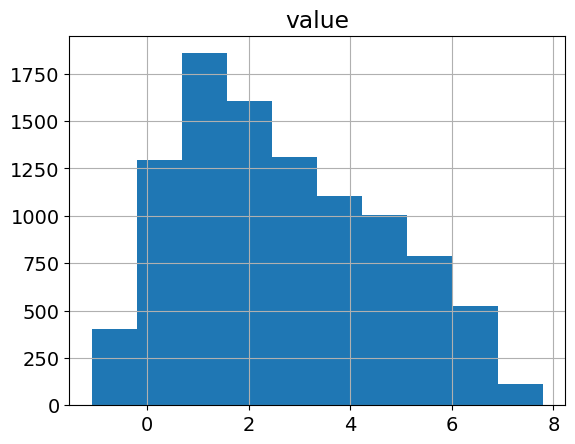

In [395]:
Mirror_statistics.hist()